In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../../dataset/The_Cancer_data_1500_V2.csv')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1500.0,50.320000,17.640968,20.000000,35.000000,51.000000,66.000000,80.000000
Gender,1500.0,0.490667,0.500080,0.000000,0.000000,0.000000,1.000000,1.000000
BMI,1500.0,27.513321,7.230012,15.000291,21.483134,27.598494,33.850837,39.958688
Smoking,1500.0,0.269333,0.443761,0.000000,0.000000,0.000000,1.000000,1.000000
GeneticRisk,1500.0,0.508667,0.678895,0.000000,0.000000,0.000000,1.000000,2.000000
PhysicalActivity,1500.0,4.897929,2.866162,0.002410,2.434609,4.834316,7.409896,9.994607
AlcoholIntake,1500.0,2.417987,1.419318,0.001215,1.210598,2.382971,3.585624,4.987115
CancerHistory,1500.0,0.144000,0.351207,0.000000,0.000000,0.000000,0.000000,1.000000
Diagnosis,1500.0,0.371333,0.483322,0.000000,0.000000,0.000000,1.000000,1.000000


In [3]:
df_numerik = df[['Age', 'BMI', 'PhysicalActivity', 'AlcoholIntake']]
df_category = df[['Gender', 'Smoking', 'GeneticRisk', 'CancerHistory']]

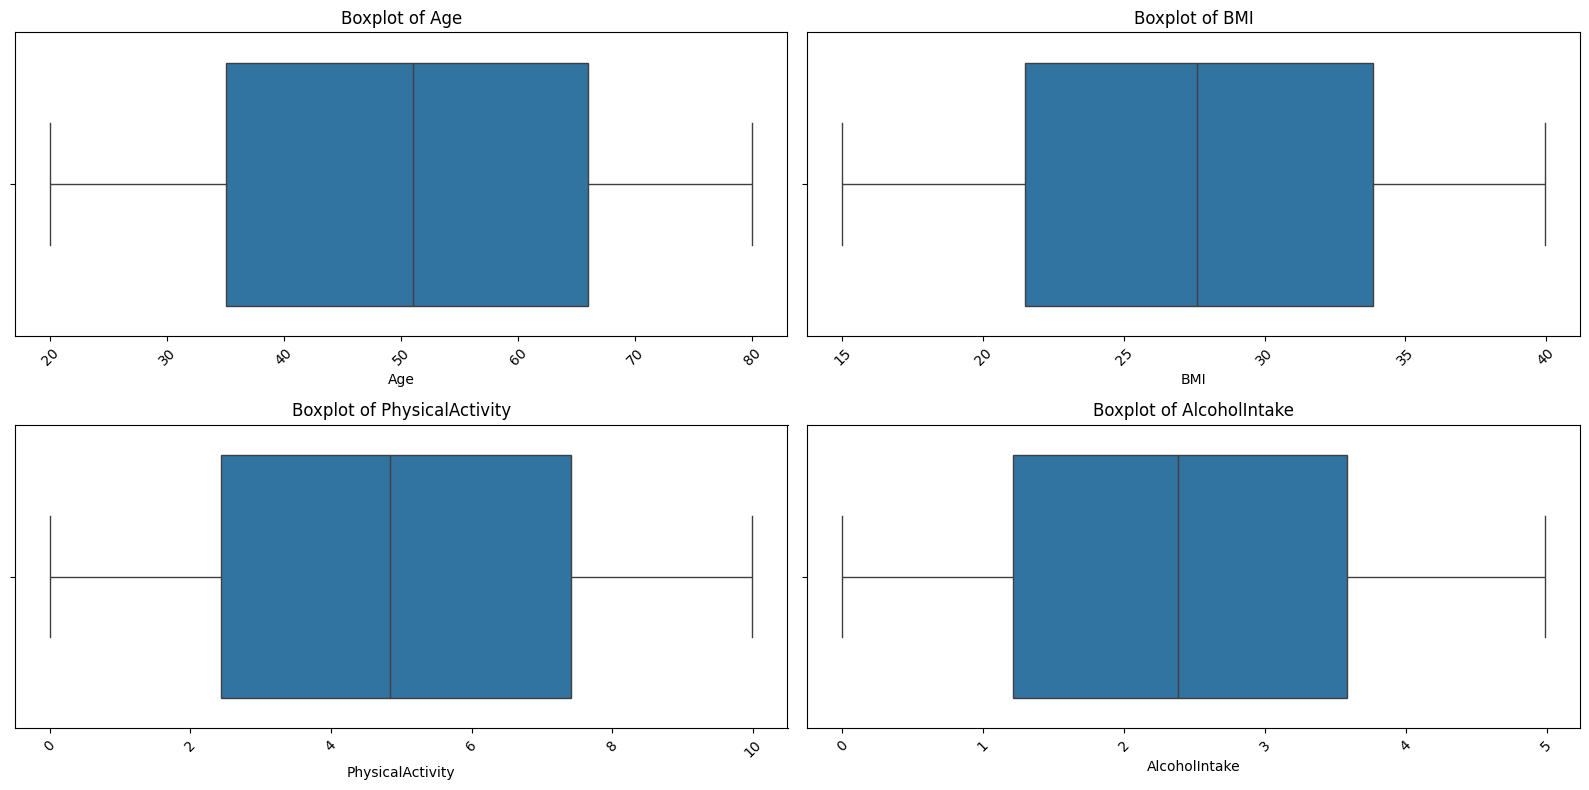

In [4]:
def plot_boxplot(df):
    n_cols = 2
    n_rows = (len(df.columns) + 1) // n_cols 
    
    plt.figure(figsize=(16, 4 * n_rows))
    
    for index, col in enumerate(df.columns):
        plt.subplot(n_rows, n_cols, index + 1)
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot of {col}")
        plt.xticks(rotation=45)
        
    plt.tight_layout()
    plt.show()


plot_boxplot(df_numerik)

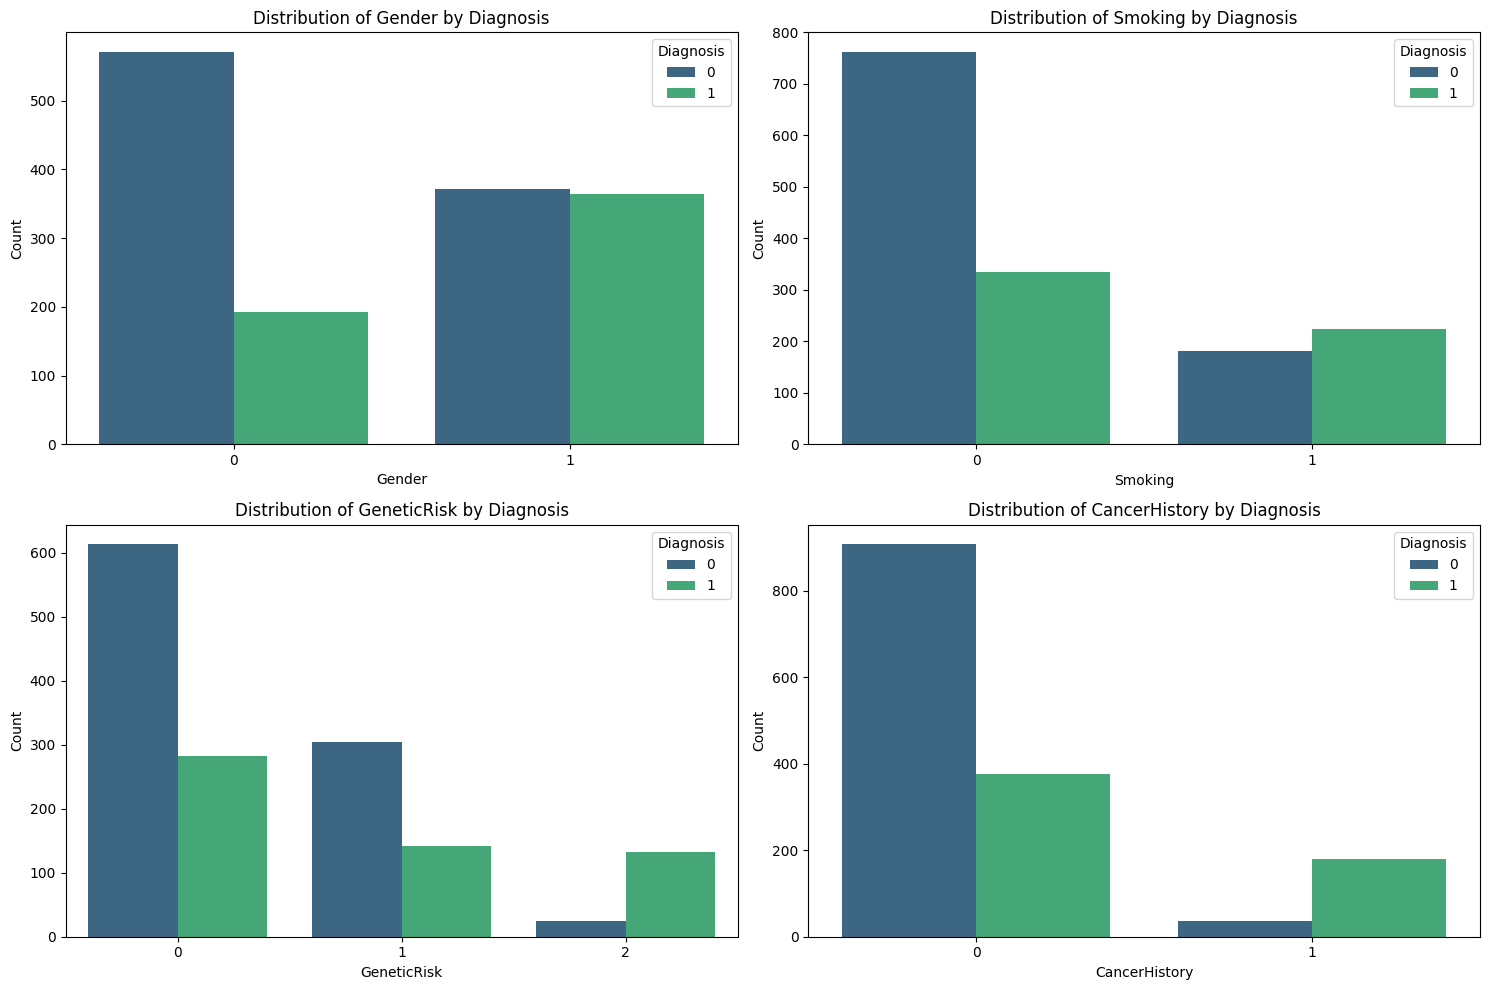

In [5]:
def plot_categories_with_diagnosis(df, category_columns, diagnosis_column):
    n_cols = 2
    n_rows = (len(category_columns) + 1) // n_cols

    plt.figure(figsize=(15, 5 * n_rows))
    
    for index, category in enumerate(category_columns):
        plt.subplot(n_rows, n_cols, index + 1)
        sns.countplot(x=category, hue=diagnosis_column, data=df, palette='viridis')        
        plt.title(f'Distribution of {category} by {diagnosis_column}')
        plt.xlabel(category)
        plt.ylabel('Count')
        plt.legend(title=diagnosis_column)
        
    plt.tight_layout()
    plt.show()

category_columns = df_category.columns
diagnosis_column = 'Diagnosis'

plot_categories_with_diagnosis(df, category_columns, diagnosis_column)

In [6]:
X = df.drop(columns='Diagnosis')
y = df['Diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1200, 8), (300, 8), (1200,), (300,))

In [7]:
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy='mean')),
    ("scaler", StandardScaler())
])

category_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
])

In [8]:
preprocessor = ColumnTransformer([
    ("numeric", numeric_pipe, df_numerik.columns),  
    ("category", category_pipe, df_category.columns)
])

In [9]:
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", SVC()),
])

In [10]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'BMI', 'PhysicalActivity', 'AlcoholIntake'], dtype='object')),
                                                 ('category',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Smoking', 'GeneticRisk', 'CancerHistory'], dtype='object'))])),
                ('algo', SVC())])

In [11]:
pipeline.score(X_test, y_test)

0.9033333333333333

In [19]:
params = [
    {"algo": [SVC()], "algo__C": [1e-3, 1e-2, 1e-1, 1e+0, 1e+1, 1e+2, 1e+3], "algo__kernel": ["linear", "poly", "rbf"], "algo__gamma": ["scale", "auto"]},
    {"algo": [RandomForestClassifier()], "algo__n_estimators": np.arange(10, 200, 10), "algo__max_features": ["sqrt", "log2"]},
    {"algo": [LogisticRegression()], "algo__C": [1e-2, 1e-1, 1e+0, 1e+1, 1e+2]}
]

model = GridSearchCV(pipeline, params, cv=3, error_score='raise', n_jobs=1, verbose=1)
model.fit(X_train, y_train)

Fitting 3 folds for each of 85 candidates, totalling 255 fits


GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Age', 'BMI', 'PhysicalActivity', 'AlcoholIntake'], dtype='object')),
                                                                        ('category',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder...
                          'algo__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                      1000.0],
                          'algo__gamma': ['scale', 'auto'],
                          'algo__kernel': ['linear', 'poly', 'rbf']},
                         {'algo': [RandomForestClassifier()],
                          'algo__max_features': ['sqrt', 'log2'],
                          'algo__n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])},
                         {'algo': [LogisticRegression()],
                          'algo__C': [0.01, 0.1, 1.0, 10.0, 100.0]}],
             verbose=1)

In [13]:
print(f"Best Parameter:{model.best_params_}")
print(f"Best Cross Validation Score: {model.best_score_:.2f}")

Best Parameter:{'algo': RandomForestClassifier(), 'algo__max_features': 'sqrt', 'algo__n_estimators': 150}
Best Cross Validation Score: 0.89


In [14]:
print(f"Test Score: {model.score(X_test, y_test):.2f}")

Test Score: 0.94


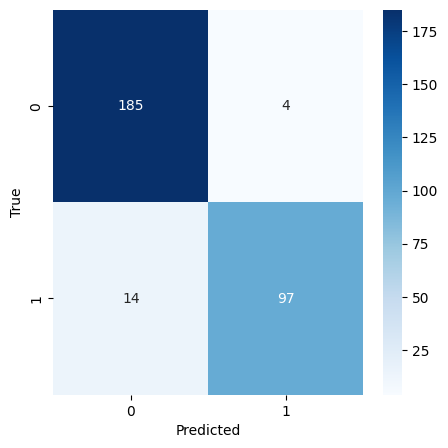

In [15]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()